# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle`
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Try and fix a central frequency and play with the width of the band, then try to change the central frequency of the band.
- Try to change the order of the filter, for a fixed frequency band. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic commeand [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [24]:
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf
from scipy.fft import fft, fftfreq
from ipywidgets import interact
import ipywidgets as widgets

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})


In [9]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Text(0, 0.5, 'voltage (mV)')

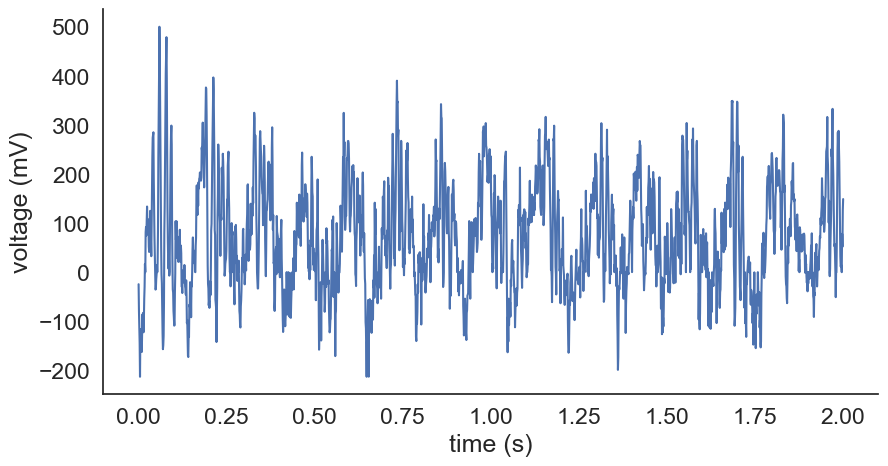

In [13]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

# Visualising a few seconds of the data
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,2000),lfp[:2000])
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

In [21]:
# Define filter object
filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

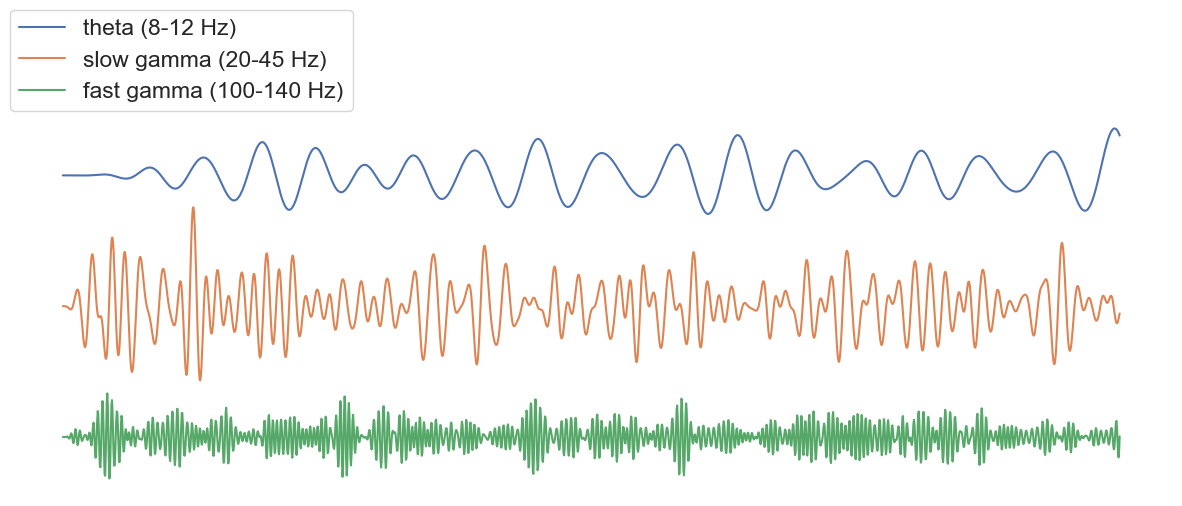

In [25]:
# Filtering the data in different frequency bands
theta_lfp = lf.bandpass_filter(lfp, low_f=8, high_f=12, sampling_rate=sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp, low_f=20, high_f=45, sampling_rate=sampling_rate)
fast_gamma_lfp = lf.bandpass_filter(lfp, low_f=100,high_f=140, sampling_rate=sampling_rate)

plot_offset = 200 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(theta_lfp[:2000]+2*plot_offset,label='theta (8-12 Hz)')
plt.plot(slow_gamma_lfp[:2000]+plot_offset,label = 'slow gamma (20-45 Hz)')
plt.plot(fast_gamma_lfp[:2000],label = 'fast gamma (100-140 Hz)')

plt.axis('off')
plt.legend(loc=(0,1))

In [40]:
# Create widget to play with all the values

def different_widths(freq, width, filter_order):
    plt.figure(figsize=(10,5))
    #filter_order = filter_order
    filter = lf.bandpass_filter(lfp, low_f = max(freq-(0.5*width), 1),
                                high_f = min(freq+(0.5*width), 100),
                                sampling_rate=sampling_rate)
    plt.plot(filter[:2000]+2*plot_offset, label = 'Filtered Wave')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(different_widths, width = widgets.FloatSlider(min=1, max=200, value=4),
                       freq = widgets.FloatSlider(min=1, max=100, value=10))

interactive(children=(FloatSlider(value=10.0, description='freq', min=1.0), FloatSlider(value=4.0, description…

<function __main__.different_widths(freq, width)>

In [38]:
print(lfp)

[ -24.765  -78.975 -108.225 ...    0.       0.       0.   ]


If we fix the central frequency and 

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). this are all real wavelet.
- How does the spectrum look different from what we computed with a complex Morlet tranform ? Comment on why do you think this might be the case.

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.